# On importe les librairies requises 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import time
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
#from kmeans_gpu import KMeans
#import torch

# On charge les images correspondantes au motifs a rechercher

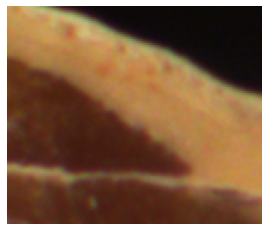

(100, 117, 3)


In [2]:
template_nucleus = cv2.imread('./Motifs/motif_nucleus_1.png')

if template_nucleus is None:
    print("Error: Could not read the image.")
else:
    # Continue with displaying the image.
    cv2.imshow('template_nucleus', template_nucleus)
    plt.imshow(cv2.cvtColor(template_nucleus, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(template_nucleus.shape)


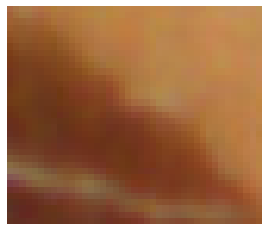

(35, 41, 3)


In [3]:
template_nucleus_2 = cv2.imread('./Motifs/motif_nucleus_2.png')

if template_nucleus_2 is None:
    print("Error: Could not read the image.")
else:
    # Continue with displaying the image.
    cv2.imshow('template_nucleus', template_nucleus_2)
    plt.imshow(cv2.cvtColor(template_nucleus_2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(template_nucleus_2.shape)


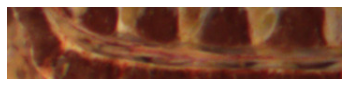

(77, 358, 3)


In [4]:
template_cotes = cv2.imread('./Motifs/colonne/motif_bas_1.png')

if template_cotes is None:
    print("Error: Could not read the image.")
else:
    # Continue with displaying the image.
    cv2.imshow('template_cotes', template_cotes)
    plt.imshow(cv2.cvtColor(template_cotes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(template_cotes.shape)


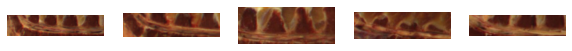

In [5]:
motif_directory = './Motifs/colonne/'

# Initialisation de la liste des motifs
liste_motifs = []

# Parcours de tous les fichiers dans le répertoire de motifs
for filename in os.listdir(motif_directory):
    # Vérification de l'extension du fichier
    if filename.endswith('.png'):
        # Construction du chemin complet du motif
        motif_path = os.path.join(motif_directory, filename)
        # Lecture du motif
        motif = cv2.imread(motif_path)
        # Vérification si la lecture a réussi
        if motif is not None:
            # Ajout du motif à la liste
            liste_motifs.append(motif)
        else:
            print(f"Error: Could not read the image {motif_path}")

# Affichage de la liste des motifs
num_motifs = len(liste_motifs)
fig, axs = plt.subplots(1, num_motifs, figsize=(10, 5))

for i, motif in enumerate(liste_motifs):
    axs[i].imshow(cv2.cvtColor(motif, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')

plt.show()

# On réalise les fonctions qui seront utilisées dans le script principal

In [6]:
def ajout_box(image):
    # On cherche le muscle nucleus
    result_nucleus = cv2.matchTemplate(image, template_nucleus, cv2.TM_CCOEFF_NORMED)
    _, max_val_nucleus, _, max_loc_nucleus = cv2.minMaxLoc(result_nucleus)
    seuil_nucleus = 0.6

    if max_val_nucleus > seuil_nucleus:
        h, w, _ = template_nucleus.shape
        top_left_nucleus = max_loc_nucleus
        bottom_right_nucleus = (top_left_nucleus[0] + w, top_left_nucleus[1] + h)
        cv2.rectangle(image, top_left_nucleus, bottom_right_nucleus, (0, 255, 0), 2)
        
        # Extraction de la région d'intérêt (ROI) correspondant à la zone détectée par "template_nucleus"
        roi_nucleus = image[top_left_nucleus[1]:bottom_right_nucleus[1], top_left_nucleus[0]:bottom_right_nucleus[0]]
        
        # Recherche de "template_nucleus_2" dans la région d'intérêt
        result_nucleus_2 = cv2.matchTemplate(roi_nucleus, template_nucleus_2, cv2.TM_CCOEFF_NORMED)
        _, max_val_nucleus_2, _, max_loc_nucleus_2 = cv2.minMaxLoc(result_nucleus_2)
        seuil_nucleus_2 = 0.6
        
        if max_val_nucleus_2 > seuil_nucleus_2:
            h_2, w_2, _ = template_nucleus_2.shape
            top_left_nucleus_2 = (max_loc_nucleus_2[0] + top_left_nucleus[0], max_loc_nucleus_2[1] + top_left_nucleus[1])
            bottom_right_nucleus_2 = (top_left_nucleus_2[0] + w_2, top_left_nucleus_2[1] + h_2)
            cv2.rectangle(image, top_left_nucleus_2, bottom_right_nucleus_2, (0, 0, 255), 2)
    
        
    # On recerche les cotes
    best_match_score = float('-inf')
    best_max_loc = None
    best_template_cotes = None

    for template_cotes in liste_motifs:
        result_cotes = cv2.matchTemplate(image, template_cotes, cv2.TM_CCOEFF_NORMED)
        _, max_val_cotes, _, max_loc_cotes = cv2.minMaxLoc(result_cotes)
        seuil_cotes = 0.4
        
        if max_val_cotes > seuil_cotes and max_val_cotes > best_match_score:
            best_match_score = max_val_cotes
            best_max_loc = max_loc_cotes
            best_template_cotes = template_cotes
    
    repere_nucleus = (0,0)
    repere_cotes = (0,0)
    if best_template_cotes is not None:
        h, w, _ = best_template_cotes.shape
        top_left_cotes = best_max_loc
        bottom_right_cotes = (top_left_cotes[0] + w, top_left_cotes[1] + h)
        cv2.rectangle(image, top_left_cotes, bottom_right_cotes, (0, 255, 0), 2)

        
        
            # On rajoute la prise de mesure grossière
        if max_val_nucleus_2 < seuil_nucleus_2 : 
            x,y = bottom_right_nucleus
            repere_nucleus = (x-40, y-40)
        else :
            x,y = bottom_right_nucleus_2
            repere_nucleus = (x, y)
            
        x_2,y_2 = top_left_cotes
        x_3, y_3 = bottom_right_cotes
        repere_cotes = (repere_nucleus[0], int((y_2+y_3) /2) )
        
        # On vérifie si les cotes sont bien situé en dessous du nucleus, si ce n'est pas le cas c'est que la détecton à été mal effectuée 
        if (repere_nucleus[1]<repere_cotes[1]):
            cv2.line(image, repere_nucleus,repere_cotes,(255, 0, 0), 2)
        else : 
            best_template_cotes = None
        
        
        
        
        
        
        
        
        
        
        
    return [image, best_template_cotes is not None,top_left_nucleus, bottom_right_nucleus,repere_nucleus,repere_cotes]
  
    #return [image, best_template_cotes is not None]


In [7]:
def traitement_kmean(image_init,k): 
    
    #image = rgb2lab(image_init)
    #image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    image = image_init
    pixel_matrix = np.array(image)
    
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = pixel_matrix.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10, n_init =10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(pixel_matrix.shape)

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [7]:
def traitement_kmean_gpu(image_init, k):
    # Convertir l'image en format adapté pour le K-Means sur GPU
    pixel_matrix = np.array(image_init)
    pixels = pixel_matrix.reshape(-1, 3)
    points = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0)

    # Appliquer K-Means pour réduire les couleurs sur GPU
    kmeans = KMeans(
        n_clusters=k,
        max_iter=100,
        tolerance=1e-4,
        distance='euclidean',
        sub_sampling=None,
        max_neighbors=15,
    )
    centroids, features = kmeans(points)

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = centroids.squeeze().numpy().astype('uint8')

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced)
    return image_reduced


In [8]:
def traitement_kmean_red(image_init,k): 
    
    #image = rgb2lab(image_init)
    #image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    image = image_init
    pixel_matrix = np.array(image)
    red_channel = image_init[:, :, 2]  # 0 correspond à la composante rouge dans l'espace RGB
    # Redimensionner la matrice des pixels en une liste de pixels
    pixels = red_channel.reshape(-1, 1)  # Nous devons redimensionner en une seule colonne pour K-Means
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_
    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(red_channel.shape)
    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [9]:
#0 = bleu
#1 = vert
#2 = rouge
def traitement_kmean_red_green(image_init, k):
 
    # Extraire les composantes rouge et verte de l'image
    red_channel = image_init[:, :, 2]  # 0 correspond à la composante rouge dans l'espace RGB
    green_channel = image_init[:, :, 1]  # 1 correspond à la composante verte dans l'espace RGB
    
    # Redimensionner la matrice des pixels en une liste de pixels pour chaque composante
    pixels_red_green = np.column_stack((red_channel.reshape(-1, 1), green_channel.reshape(-1, 1)))
    
    # Appliquer K-Means pour réduire les couleurs pour chaque composante
    kmeans_red_green = KMeans(n_clusters=k, random_state=10)
    kmeans_red_green.fit(pixels_red_green)
    labels_red_green = kmeans_red_green.predict(pixels_red_green)
    cluster_centers_red_green = kmeans_red_green.cluster_centers_

    # Remplacer les valeurs des composantes rouge et verte par les valeurs moyennes des catégories
    red_channel_reduced = cluster_centers_red_green[:, 0][labels_red_green].reshape(red_channel.shape)
    green_channel_reduced = cluster_centers_red_green[:, 1][labels_red_green].reshape(green_channel.shape)

    # Créer une nouvelle image à partir des composantes rouge et verte réduites
    image_reduced = image_init.copy()
    image_reduced[:, :, 2] = red_channel_reduced.astype('uint8')
    image_reduced[:, :, 1] = green_channel_reduced.astype('uint8')/2
    image_reduced[:, :, 0] = 0
    return image_reduced


In [10]:
def traitement_kmean_YUV(image_init,k): 
    
    image = rgb2lab(image_init)
    image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    
    pixel_matrix = np.array(image)
    
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = pixel_matrix.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(pixel_matrix.shape)

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [11]:
def traitement_kmean_lab(image_init, k):
    # Conversion de l'image BGR en RGB
    image_rgb = cv2.cvtColor(image_init, cv2.COLOR_BGR2RGB)
    # Conversion de l'image RGB en LAB
    image_lab = rgb2lab(image_rgb)
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = image_lab.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_
    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(image_lab.shape)
    # Convertir l'image LAB réduite en RGB
    image_reduced_rgb = lab2rgb(pixels_reduced)
    # Assurer que les valeurs des pixels sont dans la plage [0, 1]
    image_reduced_rgb = np.clip(image_reduced_rgb, 0, 1)
    # Convertir l'image réduite en RGB en entiers dans la plage [0, 255]
    image_reduced_rgb = (image_reduced_rgb * 255).astype('uint8')
    # Créer une nouvelle image à partir des pixels réduits en RGB
    image_reduced = Image.fromarray(image_reduced_rgb)
    return image_reduced

In [12]:
def traitement_kmean_hsv(image_init, k):
    # Conversion de l'image BGR en RGB
    image_rgb = cv2.cvtColor(image_init, cv2.COLOR_BGR2RGB)
    # Conversion de l'image RGB en HSV
    image_hsv = rgb2hsv(image_rgb)
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = image_hsv.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_
    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(image_hsv.shape)
    # Convertir l'image HSV réduite en RGB
    image_reduced_rgb = hsv2rgb(pixels_reduced)
    # Assurer que les valeurs des pixels sont dans la plage [0, 1]
    image_reduced_rgb = np.clip(image_reduced_rgb, 0, 1)
    # Convertir l'image réduite en RGB en entiers dans la plage [0, 255]
    image_reduced_rgb = (image_reduced_rgb * 255).astype('uint8')
    # Créer une nouvelle image à partir des pixels réduits en RGB
    #image_reduced = Image.fromarray(image_reduced_rgb)
    return image_reduced_rgb

# Traitement du dossier

## Ajout des zones

In [9]:
dossier_source = "./Images_originales"
chemin_destination = "./Images_finales"
nb_images = 0 
images_valides = 0
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        img = cv2.imread(chemin_image)
        image_traitee = ajout_box(img)
        images_valides += image_traitee[1]
        image_traitee = image_traitee[0]
        image_traitee = cv2.cvtColor(image_traitee, cv2.COLOR_BGR2RGB)
        
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        Image.fromarray(image_traitee).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images. dont {images_valides} images valides")


Le programme a mis 20.92230772972107 secondes à s'exécuter pour 326 images. dont 292 images valides


## KMEAN

In [19]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_3"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean(img,3)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Le programme a mis 175.91292238235474 secondes à s'exécuter pour 326 images.


## GPU 

In [36]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_gpu"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_gpu(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


ValueError: not enough values to unpack (expected 2, got 1)

In [21]:
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_red"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_red(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 188.49964666366577 secondes à s'exécuter pour 326 images.


In [19]:
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_red_green"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)    
        
        image_traitee = traitement_kmean_red_green(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")

Le programme a mis 186.76859211921692 secondes à s'exécuter pour 326 images.


## LAB

In [100]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_LAB"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_lab(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 273.25305247306824 secondes à s'exécuter pour 326 images.


## YUV

In [101]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_YUV"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_YUV(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 223.81451106071472 secondes à s'exécuter pour 326 images.


## HSV

In [67]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_HSV_2"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(chemin_image)
        image_traitee_rgb = traitement_kmean_hsv(img,2)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        #image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# Algorithmes de détection des contours


## Canny edge detector

In [93]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_canny_edge"
nb_images = 0 
temps_debut = time.time()

lower_threshold = 100
upper_threshold = 150

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(chemin_image)
        
        img = cv2.imread(chemin_image, cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(img, lower_threshold, upper_threshold)
     
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        Image.fromarray(edges).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 2.0895116329193115 secondes à s'exécuter pour 326 images.


## Sobel Operator

In [94]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_sobel_operator"
nb_images = 0 
temps_debut = time.time()


for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        image = cv2.imread(chemin_image)
        
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobelx**2 + sobely**2)
        edges = edges.astype(np.uint8)
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        Image.fromarray(edges).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 4.977395296096802 secondes à s'exécuter pour 326 images.


## contours actifs

In [99]:
from skimage.segmentation import active_contour

# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_contours_actifs"
nb_images = 0 
temps_debut = time.time()

# Définir un contour initial (vous devrez ajuster cela en fonction de votre image)
initial_snake = np.array([[x, y] for x, y in zip(np.linspace(0, image.shape[1], 100), np.linspace(0, image.shape[0], 100))])

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        image = cv2.imread(chemin_image)
        
        snake = active_contour(image, initial_snake, alpha=0.015, beta=10, gamma=0.001, coordinates='xy')
        snake = snake.astype(np.uint8)

        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        Image.fromarray(snake).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


UnboundLocalError: local variable 'snake_xy' referenced before assignment

In [1]:
from kmeanstf import KMeansTF

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed

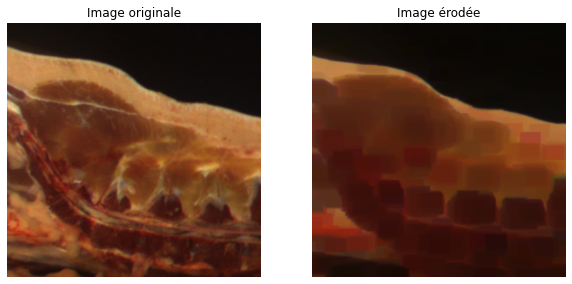

In [7]:
import matplotlib.pyplot as plt

# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Définir le noyau structurant
kernel = np.ones((20,30), np.uint8)  # Noyau de 5x5 avec tous les éléments à 1

# Appliquer l'érosion
image_eroded = cv2.erode(image, kernel, iterations=1)

# Afficher les images avec matplotlib
plt.figure(figsize=(10, 5))

# Afficher l'image originale
plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
plt.axis('off')

# Afficher l'image érodée
plt.subplot(1, 2, 2)
plt.title('Image érodée')
plt.imshow(cv2.cvtColor(image_eroded, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
plt.axis('off')

plt.show()


D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


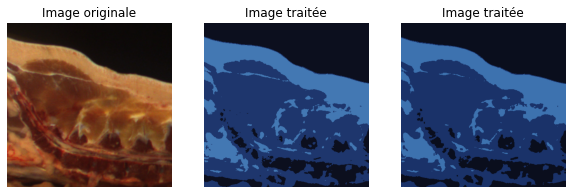

In [23]:
import matplotlib.pyplot as plt

# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Définir le noyau structurant
kernel = np.ones((3, 3), np.uint8)  # Noyau de 5x5 avec tous les éléments à 1

# Appliquer l'érosion
image_eroded = cv2.erode(image, kernel, iterations=1)

# Afficher les images avec matplotlib
plt.figure(figsize=(10, 5))

# Afficher l'image originale
plt.subplot(1, 3, 1)
plt.title('Image originale')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
plt.axis('off')

# Appliquer le traitement K-Means à l'image érodée
image_traitee_1 = traitement_kmean(image, 3)
image_traitee_2 = traitement_kmean(image_eroded, 3)

# Afficher l'image kmean
plt.subplot(1, 3, 2)
plt.title('Image traitée')
plt.imshow(image_traitee_1)  # Matplotlib attend déjà une image au format RGB
plt.axis('off')

# Afficher l'image kmean érodée
plt.subplot(1, 3, 3)
plt.title('Image traitée')
plt.imshow(image_traitee_2)  # Matplotlib attend déjà une image au format RGB
plt.axis('off')
plt.show()


## Histogrammes suivant les différents formats d'images

## RGB

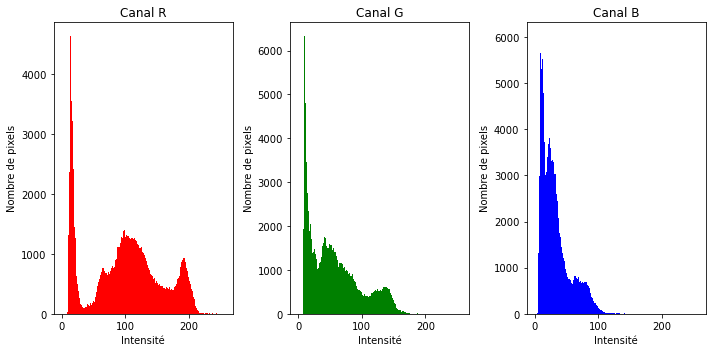

In [1]:
import cv2
import matplotlib.pyplot as plt

# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Convertir l'image en espace couleur RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Séparer les canaux RGB
R, G, B = cv2.split(image_rgb)

# Créer un histogramme pour chaque canal
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(R.ravel(), bins=256, range=(0, 256), color='red')
plt.title('Canal R')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 2)
plt.hist(G.ravel(), bins=256, range=(0, 256), color='green')
plt.title('Canal G')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 3)
plt.hist(B.ravel(), bins=256, range=(0, 256), color='blue')
plt.title('Canal B')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()


## LAB

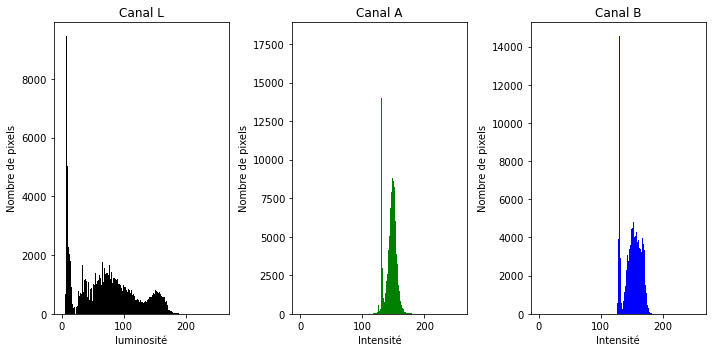

In [9]:
# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Convertir l'image en espace couleur LAB
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Séparer les canaux LAB
L, A, B = cv2.split(image_lab)

# Créer un histogramme pour chaque canal
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(L.ravel(), bins=256, range=(0, 256), color='black')
plt.title('Canal L')
plt.xlabel('luminosité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 2)
plt.hist(A.ravel(), bins=256, range=(0, 256), color='green')
plt.title('Canal A')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 3)
plt.hist(B.ravel(), bins=256, range=(0, 256), color='blue')
plt.title('Canal B')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()


## YUV

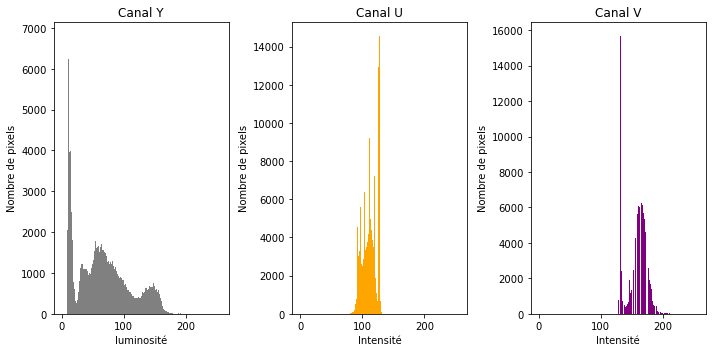

In [8]:
# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Convertir l'image en espace couleur YUV
image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

# Séparer les canaux YUV
Y, U, V = cv2.split(image_yuv)

# Créer un histogramme pour chaque canal
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(Y.ravel(), bins=256, range=(0, 256), color='gray')
plt.title('Canal Y')
plt.xlabel('luminosité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 2)
plt.hist(U.ravel(), bins=256, range=(0, 256), color='orange')
plt.title('Canal U')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 3)
plt.hist(V.ravel(), bins=256, range=(0, 256), color='purple')
plt.title('Canal V')
plt.xlabel('Intensité')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()

## HSV

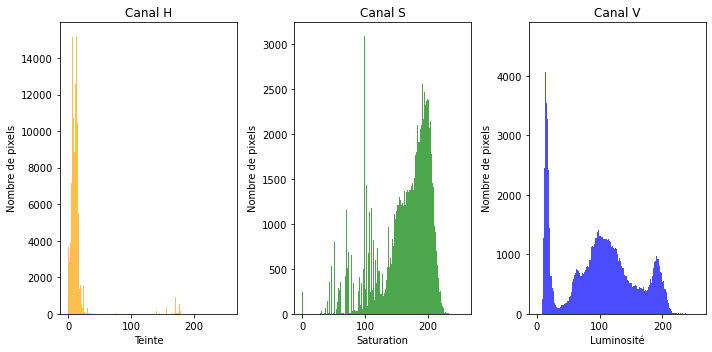

In [7]:

# Charger l'image
image = cv2.imread("./Images_originales/000002.jpg")

# Convertir l'image en espace couleur HSV
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Séparer les canaux HSV
H, S, V = cv2.split(image_hsv)

# Créer un histogramme pour chaque canal
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(H.ravel(), bins=256, range=(0, 256), color='orange', alpha=0.7)
plt.title('Canal H')
plt.xlabel('Teinte')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 2)
plt.hist(S.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
plt.title('Canal S')
plt.xlabel('Saturation')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 3)
plt.hist(V.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
plt.title('Canal V')
plt.xlabel('Luminosité')
plt.ylabel('Nombre de pixels')

plt.tight_layout()
plt.show()


In [90]:
#!/usr/bin/env python

"""
Ensemble de fonctions utilitaires pour l'analyse de l'image.
"""

import cv2 as cv
import math

__author__ = "Bastien Baudouin, Guillaume Polizzi"


def reframeImage(img, minX, maxX, minY, maxY):
    """
    Renvoie une portion de l'image.

    img: l'image à recadrer
    minX: Coordonnée X du coin supérieur gauche de l'image recadrée 
    maxX: Coordonnée X du coin inférieur droit de l'image recadrée
    minY: Coordonnée Y du coin supérieur gauche de l'image recadrée
    maxY: Coordonnée Y du coin inférieur droit de l'image recadrée

    return l'image recadrée
    """
    return img[minY:maxY, minX:maxX]


def measureFatThickness(img, img_originale, coord_fat, coord_muscle , affichage=False):
    """
    Mesure l'épaisseur minimale de la couche de gras sur une image.

    img: l'image à analyser

    return l'épaisseur de la couche de gras
    """
    # Limites de la couche du gras
    topLimit = []
    bottomLimit = []
    # Seuil d'acceptation
    differenceThresold = 70

    # Recadrage manuel autour du nucleus medius
    img = reframeImage(img, 0, 300, 0, 400)

    # Recherche des pixels qui délimitent la couche de gras
    for x in range(0, img.shape[1]):
        color = img[0][x][2]
        layers = 0
        for y in range(0, img.shape[0]):
            if layers > 1:
                break
            #print(" x: " + str(x) + " y: " + str(y) + " red: " + str(img[y][x][2]) + "\tcolor: " + str(color) + " diff: " + str(abs(int(img[y][x][2]) - color)))
            if (abs(int(img[y][x][2]) - color) > differenceThresold): 
                if layers == 0:
                    topLimit.append((x, y))
                    color = int(img[y][x][2])
                    img[y][x] = [0, 0, 255]

                else:
                    bottomLimit.append((x, y))
                    color = int(img[y][x][2])
                    img[y][x] = [0, 255, 0]

                layers += 1
        
    # Calcul de l'épaisseur minimale de la couche de gras
    distance, cords = findSmallestThickness(topLimit, bottomLimit)
    print("Epaisseur minimale de la couche de gras: " + str(distance) + " pixels et ses coordonnées sont")
    print(cords)

    #img[cords[0][1]][cords[0][0]] = [255, 0, 0]
    #img[cords[1][1]][cords[1][0]] = [255, 0, 0]

    #cv.namedWindow("Display window", cv.WINDOW_NORMAL)
    #cv.resizeWindow("Display window", 800, 900)
    #cv.imshow("Display window", img)
    #k = cv.waitKey(0) # Wait for a keystroke in the window
    
    res = ajout_box(img_originale)
    image_reduced = Image.fromarray(img.astype('uint8')) 
    coord_1 = res[2]
    coord_2 = res[3]
    coord_3 = res[4]
    coord_4 = res[5]
    
    image_reduced_np = np.array(image_reduced)
    cv2.line(image_reduced_np, cords[0], cords[1], [255, 0, 0], 2)

    #cv2.rectangle(image_reduced_np, coord_1,coord_2,(255, 0, 0), 2)
    cv2.rectangle(image_reduced_np, coord_3,coord_4,(255, 0, 0), 2)

    
    # On rajoute les mesure effectué à la main
    print( cords[0], cords[1])
    print("coords_fat")
    print((int(coord_fat[0]),int(coord_fat[1])) , (int(coord_fat[2]),int(coord_fat[3])))
    cv2.line(image_reduced_np, (int(coord_fat[0]),int(coord_fat[1])) , (int(coord_fat[2]),int(coord_fat[3])), (0, 255, 255), 1)
    cv2.line(image_reduced_np, (int(coord_muscle[0]),int(coord_muscle[1])) , (int(coord_muscle[2]),int(coord_muscle[3])), (0, 255, 255), 1)

    if (affichage):
        image_reduced = Image.fromarray(image_reduced_np)
        image_reduced.show(title=f'Image réduite en 2 catégories')

    effective_musle = (res[4][1]-res[5][1])
    print("cords[0]")
    print(cords[0])
    PV1 = (cords[0])
    PV2 = (cords[1])
    return distance,effective_musle, PV1, PV2
    #return 0

In [9]:
def traitement_kmean(image_init,k): 
    
    #image = rgb2lab(image_init)
    #image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    image = image_init
    pixel_matrix = np.array(image)
    
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = pixel_matrix.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(pixel_matrix.shape)

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [39]:
#!/usr/bin/env python
"""
Programme principal d'analyse d'images de carcasses de porc.
"""
import cv2 as cv


__author__ = "Bastien Baudouin, Guillaume Polizzi"

img = cv2.imread("./Images_originales/000004.jpg")

# Appliquer le traitement K-Means
image_reduced = traitement_kmean(img, 2)
#image_kmean = image_reduced

#image_reduced.save("./Images_kmean_2/test-simplified-1.png", format='PNG')
image_traitee_rgb = cv2.cvtColor(np.array(image_reduced), cv2.COLOR_BGR2RGB)
Image.fromarray(image_traitee_rgb).save("test-simplified-1.jpg")
#image_reduced.save("test-simplified-1.jpg")


#image_kmean = cv2.imread("./Images_kmean_2/000004.jpg")
image_kmean = cv2.imread("test-simplified-1.jpg")


#image_reduced.show(title=f'Image réduite en 2 catégories')

#cv.namedWindow("Display window", cv.WINDOW_NORMAL)
#cv.resizeWindow("Display window", 800, 900)
#cv.imshow("Display window", image_reduced)
#k = cv.waitKey(0) # Wait for a keystroke in the window
#image = Image.open(r"C:\Users\Guillaume\Documents\PTRANS\Images_originales\000004.jpg")
measureFatThickness(image_kmean,img)

TypeError: measureFatThickness() missing 2 required positional arguments: 'coord_fat' and 'coord_muscle'

In [102]:
import csv
#Si on souhaite l'affichage des images avec les mesures (lent)
affichage = False
préfixe = "./Images_originales/"
# Ouverture du fichier CSV en mode lecture
temps_debut = time.time()

# Permet de ne pas refaire les calculs si l'on souhauite juste tester les stats
nb_images = 0
fat_mesures = []
muscle_measures = []
fat_theorical = []
muscle_theorical = []
PG1_difference = []
PG2_difference = []
with open('Mesures_de_test - Feuille 1.csv', newline='') as csvfile:
        # Création d'un lecteur CSV basé sur les dictionnaires
        lecteur_csv = csv.DictReader(csvfile)

        # Parcourir chaque ligne du fichier CSV
        for ligne in lecteur_csv:
            nb_images +=1
            
            # Accéder aux valeurs par les noms de colonnes
            print(ligne)
            cle, valeurs = list(ligne.items())[0]
            
            # IF SYSTEM = MACOS 
            #nom_image, mesure_gras, mesure_muscle = valeurs.split(',')
            
            # IF SYSTEM = WINDOWS
            #nom_image, mesure_gras, mesure_muscle = ligne['Nom_Image'], ligne['Mesure_Gras'], ligne['Mesure_Muscle']
            nom_image, PG1x, PG1y, PG2x, PG2y, mesure_gras, PV1x, PV1y, PV2x, PV2y, mesure_muscle = ligne['Nom'], ligne['PG1x'], ligne['PG1y'], ligne['PG2x'], ligne['PG2y'], ligne['G'], ligne['PV1x'], ligne['PV1y'], ligne['PV2x'], ligne['PV2y'], ligne['V']
            # Convertir les mesures de gras et de muscle en entiers
            mesure_gras = float(mesure_gras)
            mesure_muscle = int(mesure_muscle)
            PV1x = int(PV1x)
            PV1y = int(PV1y)
            PV2x = int(PV2x)
            PV2y = int(PV2y)
            
            PG1x = int(PG1x)
            PG1y = int(PG1y)
            PG2x = int(PG2x)
            PG2y = int(PG2y)            
            #Les points de mesures obtenu à la main pour les comparer graphiquements sur l'image
            coord_fat = [PG1x, PG1y, PG2x, PG2y]
            coord_muscle = [PV1x, PV1y, PV2x, PV2y]
            
            img = cv2.imread(préfixe + nom_image)
            image_reduced = traitement_kmean(img, 2)
            image_traitee_rgb = cv2.cvtColor(np.array(image_reduced), cv2.COLOR_BGR2RGB)
            Image.fromarray(image_traitee_rgb).save("test-simplified-1.jpg")
            image_kmean = cv2.imread("test-simplified-1.jpg")        
            effective_fat, effective_musle, PG1, PG2 = measureFatThickness(image_kmean,img,coord_fat, coord_muscle, affichage)

            # Ajout des mesures aux listes
            fat_mesures.append(effective_fat)
            muscle_measures.append(effective_musle)
            fat_theorical.append(mesure_gras)
            muscle_theorical.append(mesure_muscle)
            print("PG1")
            print("x")
            print(PG1[0], PG1x)
            print("y")
            print(PG1[1], PG1y)


            PG1_difference.append( (PG1[0]- PG1x ,PG1[1]- PG1y ) )
            PG2_difference.append( (PG2[0]- PG2x ,PG2[1]- PG2y ) )

            if nb_images == 51 :
                break

print(PG1_difference)
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")

{'Nom': '000002.jpg', 'PG1x': '210', 'PG1y': '99', 'PG2x': '187', 'PG2y': '123', 'G': '33.24', 'PV1x': '208', 'PV1y': '142', 'PV2x': '208', 'PV2y': '305', 'V': '163'}
Epaisseur minimale de la couche de gras: 38.600518131237564 pixels et ses coordonnées sont
[(209, 98), (186, 129)]
(209, 98) (186, 129)
coords_fat
(210, 99) (187, 123)
cords[0]
(209, 98)
PG1
x
209 210
y
98 99
{'Nom': '000004.jpg', 'PG1x': '150', 'PG1y': '53', 'PG2x': '142', 'PG2y': '80', 'G': '28.16', 'PV1x': '223', 'PV1y': '122', 'PV2x': '223', 'PV2y': '257', 'V': '135'}
Epaisseur minimale de la couche de gras: 30.805843601498726 pixels et ses coordonnées sont
[(149, 53), (142, 83)]
(149, 53) (142, 83)
coords_fat
(150, 53) (142, 80)
cords[0]
(149, 53)
PG1
x
149 150
y
53 53
{'Nom': '000005.jpg', 'PG1x': '192', 'PG1y': '77', 'PG2x': '173', 'PG2y': '105', 'G': '33.84', 'PV1x': '189', 'PV1y': '117', 'PV2x': '189', 'PV2y': '251', 'V': '134'}
Epaisseur minimale de la couche de gras: 38.62641583165593 pixels et ses coordonnées 

Epaisseur minimale de la couche de gras: 2.0 pixels et ses coordonnées sont
[(21, 49), (21, 51)]
(21, 49) (21, 51)
coords_fat
(162, 15) (157, 54)
cords[0]
(21, 49)
PG1
x
21 162
y
49 15
{'Nom': '000058.jpg', 'PG1x': '128', 'PG1y': '14', 'PG2x': '120', 'PG2y': '40', 'G': '27.2', 'PV1x': '159', 'PV1y': '65', 'PV2x': '159', 'PV2y': '198', 'V': '133'}
Epaisseur minimale de la couche de gras: 1.0 pixels et ses coordonnées sont
[(50, 46), (50, 47)]
(50, 46) (50, 47)
coords_fat
(128, 14) (120, 40)
cords[0]
(50, 46)
PG1
x
50 128
y
46 14
{'Nom': '000060.jpg', 'PG1x': '183', 'PG1y': '24', 'PG2x': '171', 'PG2y': '40', 'G': '20', 'PV1x': '216', 'PV1y': '76', 'PV2x': '216', 'PV2y': '234', 'V': '158'}
Epaisseur minimale de la couche de gras: 1.0 pixels et ses coordonnées sont
[(57, 37), (56, 37)]
(57, 37) (56, 37)
coords_fat
(183, 24) (171, 40)
cords[0]
(57, 37)
PG1
x
57 183
y
37 24
{'Nom': '000065.jpg', 'PG1x': '96', 'PG1y': '13', 'PG2x': '92', 'PG2y': '27', 'G': '14.56', 'PV1x': '190', 'PV1y': '72'

Epaisseur minimale de la couche de gras: 2.0 pixels et ses coordonnées sont
[(35, 45), (37, 45)]
(35, 45) (37, 45)
coords_fat
(200, 53) (191, 69)
cords[0]
(35, 45)
PG1
x
35 200
y
45 53
{'Nom': '000109.jpg', 'PG1x': '144', 'PG1y': '77', 'PG2x': '140', 'PG2y': '93', 'G': '16.49', 'PV1x': '271', 'PV1y': '140', 'PV2x': '271', 'PV2y': '305', 'V': '165'}
Epaisseur minimale de la couche de gras: 1.0 pixels et ses coordonnées sont
[(3, 56), (3, 57)]
(3, 56) (3, 57)
coords_fat
(144, 77) (140, 93)
cords[0]
(3, 56)
PG1
x
3 144
y
56 77
{'Nom': '000112.jpg', 'PG1x': '178', 'PG1y': '42', 'PG2x': '177', 'PG2y': '54', 'G': '12.04', 'PV1x': '271', 'PV1y': '108', 'PV2x': '271', 'PV2y': '253', 'V': '145'}
Epaisseur minimale de la couche de gras: 17.88854381999832 pixels et ses coordonnées sont
[(211, 51), (203, 67)]
(211, 51) (203, 67)
coords_fat
(178, 42) (177, 54)
cords[0]
(211, 51)
PG1
x
211 178
y
51 42
{'Nom': '000113.jpg', 'PG1x': '229', 'PG1y': '83', 'PG2x': '225', 'PG2y': '103', 'G': '20.4', 'PV1x

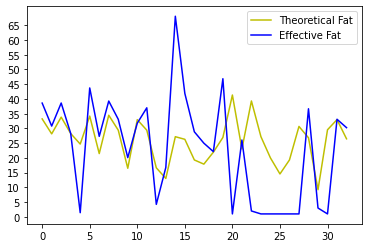

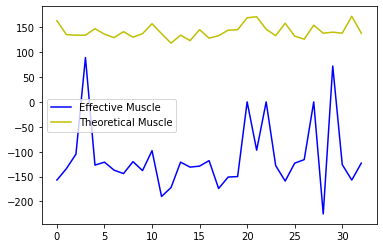

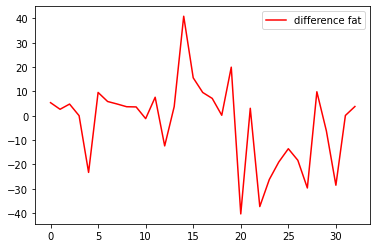

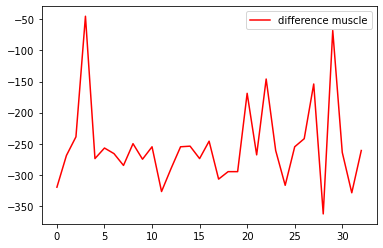

In [76]:
# Affichage graphique des résultats
plt.plot(fat_theorical, 'y', label='Theoretical Fat')
plt.plot(fat_mesures, 'b', label='Effective Fat')
plt.yticks(np.arange(0, max(max(fat_mesures), max(fat_theorical)), step=5))
plt.legend()
plt.show()

plt.plot(muscle_measures, 'b', label='Effective Muscle')
plt.plot(muscle_theorical, 'y', label='Theoretical Muscle')
plt.legend()
plt.show()

# Affichage de l'écart à la valeur théorique
# Convertir les listes en tableaux NumPy
fat_mesures_array = np.array(fat_mesures)
fat_theorical_array = np.array(fat_theorical)
muscle_mesures_array = np.array(muscle_measures)
muscle_theorical_array = np.array(muscle_theorical)

# Calculer la différence entre les valeurs mesurées et théoriques
difference_fat = fat_mesures_array - fat_theorical_array
plt.plot(difference_fat, 'r', label='difference fat')
plt.legend()
plt.show()

# Calculer la différence entre les valeurs mesurées et théoriques
difference_muscle = muscle_mesures_array - muscle_theorical_array
plt.plot(difference_muscle, 'r', label='difference muscle')
plt.legend()
plt.show()

[(-1, -1), (-1, 0), (1, 0), (-4, -1), (-248, 21), (54, 19), (14, 7), (-8, -3), (-8, -3), (-61, -14), (-45, -9), (13, 4), (-198, 33), (-5, -2), (-117, -30), (81, 33), (60, 16), (-7, -2), (-10, -3), (-156, -30), (-202, 45), (-8, 0), (-141, 34), (-78, 32), (-126, 13), (-65, 40), (-168, 7), (-260, -32), (-168, -37), (-211, 19), (-128, 12), (123, 51), (2, 0), (-218, -46), (51, 23), (-170, 55), (1, 0), (2, 1), (-43, -9), (-131, -18), (-12, -4), (-258, -35), (-10, -3), (-202, 24), (-196, 36), (-165, -8), (-141, -21), (33, 9), (-1, -1), (-235, 34)]


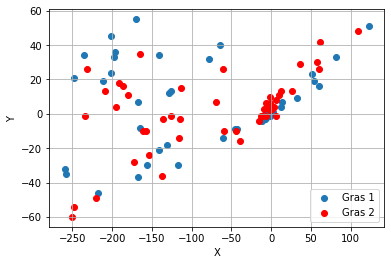

In [106]:
# Différence des points de mesures : 
print(PG1_difference)
# Extraire les coordonnées x et y
x_1 = [point[0] for point in PG1_difference]
y_1 = [point[1] for point in PG1_difference]

x_2 = [point[0] for point in PG2_difference]
y_2 = [point[1] for point in PG2_difference]

fig, ax = plt.subplots()
ax.scatter(x_1,y_1, label="Gras 1")
ax.scatter(x_2,y_2, color='r', label = "Gras 2")

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
from scipy import stats

# Calculer des statistiques pour la différence de graisse
mean_fat_diff = np.mean(difference_fat)
median_fat_diff = np.median(difference_fat)
std_fat_diff = np.std(difference_fat)
skew_fat_diff = stats.skew(difference_fat)
kurtosis_fat_diff = stats.kurtosis(difference_fat)

# Calculer des statistiques pour la différence de muscle
mean_muscle_diff = np.mean(difference_muscle)
median_muscle_diff = np.median(difference_muscle)
std_muscle_diff = np.std(difference_muscle)
skew_muscle_diff = stats.skew(difference_muscle)
kurtosis_muscle_diff = stats.kurtosis(difference_muscle)

# Affichage des statistiques
print("Statistiques pour la différence de graisse :")
print("Moyenne:", mean_fat_diff)
print("Médiane:", median_fat_diff)
print("Écart type:", std_fat_diff)
print("Skewness:", skew_fat_diff)
print("Kurtosis:", kurtosis_fat_diff)
print()

print("Statistiques pour la différence de muscle :")
print("Moyenne:", mean_muscle_diff)
print("Médiane:", median_muscle_diff)
print("Écart type:", std_muscle_diff)
print("Skewness:", skew_muscle_diff)
print("Kurtosis:", kurtosis_muscle_diff)

Statistiques pour la différence de graisse :
Moyenne: -2.8604666266097465
Médiane: 3.056809620810597
Écart type: 17.079826588509263
Skewness: -0.28969284088331093
Kurtosis: 0.24651221982749183

Statistiques pour la différence de muscle :
Moyenne: -253.78787878787878
Médiane: -264.0
Écart type: 67.24390592001068
Skewness: 1.5255469466036828
Kurtosis: 2.3843097884381885
